In [ ]:
!pip install scikeras


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Reshape
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount("/content/drive")

# Path to dataset folder
path = "/content/drive/MyDrive/Project_HPC_for_AI"

# Load datasets
train_df = pd.read_csv(f"{path}/train.csv")
test_df = pd.read_csv(f"{path}/test.csv")
gender_submission = pd.read_csv(f"{path}/gender_submission.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data preprocessing
def preprocess_data(df, is_train=True):
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna('S', inplace=True)
    df['Fare'].fillna(df['Fare'].median(), inplace=True)

    df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
    df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])

    selected_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
    X = df[selected_features]

    if is_train:
        y = df['Survived']
        return X, y
    else:
        return X

In [ ]:

# Preprocess datasets
X_train, y_train = preprocess_data(train_df)


<ipython-input-6-fcddada051e6>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
<ipython-input-6-fcddada051e6>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [ ]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
# Reshape data for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

In [ ]:
# Define CNN model creation function
def create_cnn_model(learning_rate=0.001, dropout_rate=0.2, filters=32, kernel_size=2):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Wrap the Keras model with KerasClassifier
cnn = KerasClassifier(model=create_cnn_model, verbose=0)

In [ ]:
# Define hyperparameter grid
param_grid = {
    'batch_size': [16, 32],
    'epochs': [20, 50],
    'learning_rate': [0.001, 0.01],
    'dropout_rate': [0.2, 0.3],
    'filters': [32, 64],
    'kernel_size': [2, 3]
}

# Manual grid search
best_params = None
best_score = 0

for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for learning_rate in param_grid['learning_rate']:
            for dropout_rate in param_grid['dropout_rate']:
                for filters in param_grid['filters']:
                    for kernel_size in param_grid['kernel_size']:
                        print(f"Testing configuration: batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}, dropout_rate={dropout_rate}, filters={filters}, kernel_size={kernel_size}")

                        # Build the CNN model
                        model = create_cnn_model(learning_rate=learning_rate, dropout_rate=dropout_rate, filters=filters, kernel_size=kernel_size)

                        # Train the model
                        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_val, y_val))

                        # Evaluate on validation set
                        y_val_proba = model.predict(X_val)
                        y_val_pred = (y_val_proba > 0.5).astype(int)
                        score = accuracy_score(y_val, y_val_pred)

                        print(f"Validation Accuracy: {score:.4f}")

                        # Update best parameters if current score is better
                        if score > best_score:
                            best_score = score
                            best_params = {
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'learning_rate': learning_rate,
                                'dropout_rate': dropout_rate,
                                'filters': filters,
                                'kernel_size': kernel_size
                            }

print(f"Best Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_score:.4f}")

# Train the best model on the full training set
best_model = create_cnn_model(
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size']
)
best_model.fit(X_train, y_train, batch_size=best_params['batch_size'], epochs=best_params['epochs'], verbose=1, validation_data=(X_val, y_val))


Testing configuration: batch_size=16, epochs=20, learning_rate=0.001, dropout_rate=0.2, filters=32, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Validation Accuracy: 0.8212
Testing configuration: batch_size=16, epochs=20, learning_rate=0.001, dropout_rate=0.2, filters=32, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Validation Accuracy: 0.7933
Testing configuration: batch_size=16, epochs=20, learning_rate=0.001, dropout_rate=0.2, filters=64, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Validation Accuracy: 0.8156
Testing configuration: batch_size=16, epochs=20, learning_rate=0.001, dropout_rate=0.2, filters=64, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Validation Accuracy: 0.8212
Testing configuration: batch_size=16, epochs=20, learning_rate=0.001, dropout_rate=0.3, filters=32, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8156
Testing configuration: batch_size=16, epochs=20, learning_rate=0.001, dropout_rate=0.3, filters=32, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Validation Accuracy: 0.8101
Testing configuration: batch_size=16, epochs=20, learning_rate=0.001, dropout_rate=0.3, filters=64, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8156
Testing configuration: batch_size=16, epochs=20, learning_rate=0.001, dropout_rate=0.3, filters=64, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Validation Accuracy: 0.8101
Testing configuration: batch_size=16, epochs=20, learning_rate=0.01, dropout_rate=0.2, filters=32, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Validation Accuracy: 0.7933
Testing configuration: batch_size=16, epochs=20, learning_rate=0.01, dropout_rate=0.2, filters=32, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Validation Accuracy: 0.8101
Testing configuration: batch_size=16, epochs=20, learning_rate=0.01, dropout_rate=0.2, filters=64, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Validation Accuracy: 0.8045
Testing configuration: batch_size=16, epochs=20, learning_rate=0.01, dropout_rate=0.2, filters=64, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Validation Accuracy: 0.7933
Testing configuration: batch_size=16, epochs=20, learning_rate=0.01, dropout_rate=0.3, filters=32, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8156
Testing configuration: batch_size=16, epochs=20, learning_rate=0.01, dropout_rate=0.3, filters=32, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Validation Accuracy: 0.8101
Testing configuration: batch_size=16, epochs=20, learning_rate=0.01, dropout_rate=0.3, filters=64, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Validation Accuracy: 0.7821
Testing configuration: batch_size=16, epochs=20, learning_rate=0.01, dropout_rate=0.3, filters=64, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Validation Accuracy: 0.8045
Testing configuration: batch_size=16, epochs=50, learning_rate=0.001, dropout_rate=0.2, filters=32, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Validation Accuracy: 0.8156
Testing configuration: batch_size=16, epochs=50, learning_rate=0.001, dropout_rate=0.2, filters=32, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Validation Accuracy: 0.8045
Testing configuration: batch_size=16, epochs=50, learning_rate=0.001, dropout_rate=0.2, filters=64, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Validation Accuracy: 0.8156
Testing configuration: batch_size=16, epochs=50, learning_rate=0.001, dropout_rate=0.2, filters=64, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Validation Accuracy: 0.8156
Testing configuration: batch_size=16, epochs=50, learning_rate=0.001, dropout_rate=0.3, filters=32, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8212
Testing configuration: batch_size=16, epochs=50, learning_rate=0.001, dropout_rate=0.3, filters=32, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8156
Testing configuration: batch_size=16, epochs=50, learning_rate=0.001, dropout_rate=0.3, filters=64, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Validation Accuracy: 0.8212
Testing configuration: batch_size=16, epochs=50, learning_rate=0.001, dropout_rate=0.3, filters=64, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.7933
Testing configuration: batch_size=16, epochs=50, learning_rate=0.01, dropout_rate=0.2, filters=32, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8101
Testing configuration: batch_size=16, epochs=50, learning_rate=0.01, dropout_rate=0.2, filters=32, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Validation Accuracy: 0.8101
Testing configuration: batch_size=16, epochs=50, learning_rate=0.01, dropout_rate=0.2, filters=64, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Validation Accuracy: 0.8101
Testing configuration: batch_size=16, epochs=50, learning_rate=0.01, dropout_rate=0.2, filters=64, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Validation Accuracy: 0.8045
Testing configuration: batch_size=16, epochs=50, learning_rate=0.01, dropout_rate=0.3, filters=32, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8156
Testing configuration: batch_size=16, epochs=50, learning_rate=0.01, dropout_rate=0.3, filters=32, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8268
Testing configuration: batch_size=16, epochs=50, learning_rate=0.01, dropout_rate=0.3, filters=64, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8045
Testing configuration: batch_size=16, epochs=50, learning_rate=0.01, dropout_rate=0.3, filters=64, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Validation Accuracy: 0.8156
Testing configuration: batch_size=32, epochs=20, learning_rate=0.001, dropout_rate=0.2, filters=32, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Validation Accuracy: 0.8212
Testing configuration: batch_size=32, epochs=20, learning_rate=0.001, dropout_rate=0.2, filters=32, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8101
Testing configuration: batch_size=32, epochs=20, learning_rate=0.001, dropout_rate=0.2, filters=64, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8156
Testing configuration: batch_size=32, epochs=20, learning_rate=0.001, dropout_rate=0.2, filters=64, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8156
Testing configuration: batch_size=32, epochs=20, learning_rate=0.001, dropout_rate=0.3, filters=32, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8212
Testing configuration: batch_size=32, epochs=20, learning_rate=0.001, dropout_rate=0.3, filters=32, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8212
Testing configuration: batch_size=32, epochs=20, learning_rate=0.001, dropout_rate=0.3, filters=64, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8156
Testing configuration: batch_size=32, epochs=20, learning_rate=0.001, dropout_rate=0.3, filters=64, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Validation Accuracy: 0.8101
Testing configuration: batch_size=32, epochs=20, learning_rate=0.01, dropout_rate=0.2, filters=32, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8156
Testing configuration: batch_size=32, epochs=20, learning_rate=0.01, dropout_rate=0.2, filters=32, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Validation Accuracy: 0.8268
Testing configuration: batch_size=32, epochs=20, learning_rate=0.01, dropout_rate=0.2, filters=64, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8212
Testing configuration: batch_size=32, epochs=20, learning_rate=0.01, dropout_rate=0.2, filters=64, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Validation Accuracy: 0.8045
Testing configuration: batch_size=32, epochs=20, learning_rate=0.01, dropout_rate=0.3, filters=32, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Validation Accuracy: 0.8212
Testing configuration: batch_size=32, epochs=20, learning_rate=0.01, dropout_rate=0.3, filters=32, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Validation Accuracy: 0.8156
Testing configuration: batch_size=32, epochs=20, learning_rate=0.01, dropout_rate=0.3, filters=64, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Validation Accuracy: 0.7765
Testing configuration: batch_size=32, epochs=20, learning_rate=0.01, dropout_rate=0.3, filters=64, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Validation Accuracy: 0.7989
Testing configuration: batch_size=32, epochs=50, learning_rate=0.001, dropout_rate=0.2, filters=32, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Validation Accuracy: 0.8212
Testing configuration: batch_size=32, epochs=50, learning_rate=0.001, dropout_rate=0.2, filters=32, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Validation Accuracy: 0.7989
Testing configuration: batch_size=32, epochs=50, learning_rate=0.001, dropout_rate=0.2, filters=64, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Validation Accuracy: 0.8268
Testing configuration: batch_size=32, epochs=50, learning_rate=0.001, dropout_rate=0.2, filters=64, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Validation Accuracy: 0.8156
Testing configuration: batch_size=32, epochs=50, learning_rate=0.001, dropout_rate=0.3, filters=32, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Validation Accuracy: 0.8212
Testing configuration: batch_size=32, epochs=50, learning_rate=0.001, dropout_rate=0.3, filters=32, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Validation Accuracy: 0.8101
Testing configuration: batch_size=32, epochs=50, learning_rate=0.001, dropout_rate=0.3, filters=64, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Validation Accuracy: 0.8045
Testing configuration: batch_size=32, epochs=50, learning_rate=0.001, dropout_rate=0.3, filters=64, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8101
Testing configuration: batch_size=32, epochs=50, learning_rate=0.01, dropout_rate=0.2, filters=32, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8101
Testing configuration: batch_size=32, epochs=50, learning_rate=0.01, dropout_rate=0.2, filters=32, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Validation Accuracy: 0.8101
Testing configuration: batch_size=32, epochs=50, learning_rate=0.01, dropout_rate=0.2, filters=64, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Validation Accuracy: 0.8156
Testing configuration: batch_size=32, epochs=50, learning_rate=0.01, dropout_rate=0.2, filters=64, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8156
Testing configuration: batch_size=32, epochs=50, learning_rate=0.01, dropout_rate=0.3, filters=32, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Validation Accuracy: 0.8212
Testing configuration: batch_size=32, epochs=50, learning_rate=0.01, dropout_rate=0.3, filters=32, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Validation Accuracy: 0.8212
Testing configuration: batch_size=32, epochs=50, learning_rate=0.01, dropout_rate=0.3, filters=64, kernel_size=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Validation Accuracy: 0.8045
Testing configuration: batch_size=32, epochs=50, learning_rate=0.01, dropout_rate=0.3, filters=64, kernel_size=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Validation Accuracy: 0.8045
Best Parameters: {'batch_size': 16, 'epochs': 50, 'learning_rate': 0.01, 'dropout_rate': 0.3, 'filters': 32, 'kernel_size': 3}
Best Validation Accuracy: 0.8268
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.7277 - loss: 0.5520 - val_accuracy: 0.7709 - val_loss: 0.4817
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8209 - loss: 0.4284 - val_accuracy: 0.7598 - val_loss: 0.5186
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7847 - loss: 0.4972 - val_accuracy: 0.7989 - val_loss: 0.4224
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8150 - loss: 0.4292 - val_accuracy: 0.8101 - val_loss: 0.4280
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8155 - loss: 0.4710 - val_accuracy: 0.8101 - val_loss: 0.4418
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8334 - loss: 0.4537 - val_accuracy: 0.8212 - val_loss: 0.4280
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8216 - loss: 0.4395 - val_accuracy: 0.7989 - val_loss: 0.4267
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8321 - loss: 0.3932 - val_accuracy: 0.8268 - val_loss: 0.4188
Ep

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import tensorflow as tf

# Evaluate the best model
y_val_proba = best_model.predict(X_val)
y_val_pred = (y_val_proba > 0.5).astype(int)

# Compute metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_proba)

print("\nValidation Metrics (Before Quantization):")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Validation Metrics (Before Quantization):
Accuracy: 0.83
Precision: 0.83
Recall: 0.73
F1-Score: 0.78
ROC-AUC: 0.87


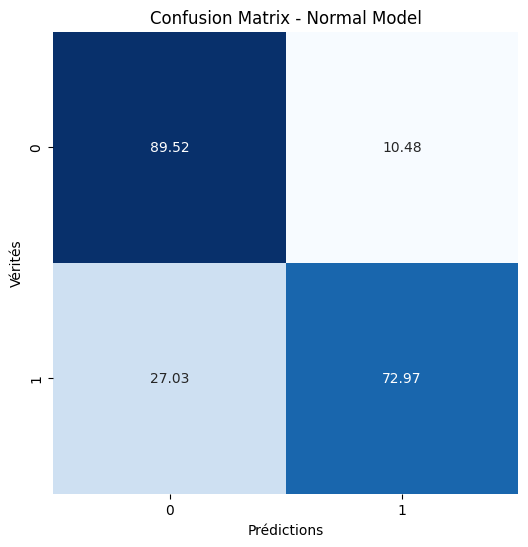

In [ ]:
# Confusion Matrix - Normal Model
conf_matrix_normal_percent = conf_matrix_normal.astype('float') / conf_matrix_normal.sum(axis=1, keepdims=True) * 100

# Afficher la matrice de confusion en pourcentage
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_normal_percent, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Normal Model")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.show()


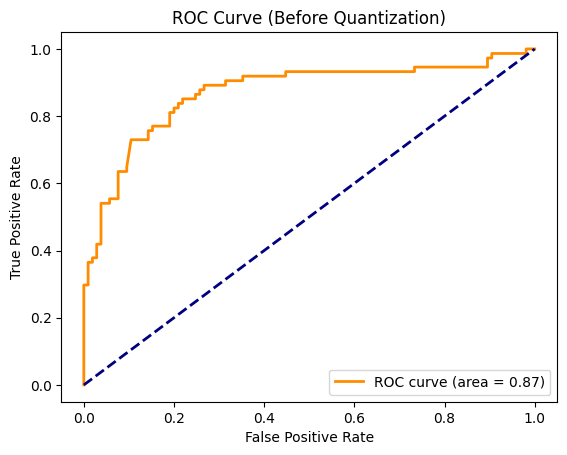

In [ ]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Before Quantization)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save the best model
best_model.save("best_cnn_model.h5")
print("Best model saved as 'best_cnn_model.h5'.")

Best model saved as 'best_cnn_model.h5'.


In [ ]:
# Quantize the best model
print("\nQuantizing the model...")
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()


Quantizing the model...
Saved artifact at '/tmp/tmpwoqbj7yx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 7, 1), dtype=tf.float32, name='keras_tensor_1856')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134105932731616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134105930576320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134105932402352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134105631077328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134105633913344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134105631070112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134105635047200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134105635049488: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
# Save the quantized model
with open("quantized_cnn_model.tflite", "wb") as f:
    f.write(tflite_model)
print("Quantized model saved as 'quantized_cnn_model.tflite'.")

Quantized model saved as 'quantized_cnn_model.tflite'.


In [ ]:
# Load and evaluate the quantized model
interpreter = tf.lite.Interpreter(model_path="quantized_cnn_model.tflite")
interpreter.allocate_tensors()

In [ ]:
def evaluate_quantized_model(interpreter, X, y):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    y_pred = []
    y_proba = []

    for i in range(len(X)):
        input_data = np.expand_dims(X[i], axis=0).astype(np.float32)  # Expand to (1, num_features, 1)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]['index'])
        y_proba.append(output[0][0])  # Probability
        y_pred.append(output[0][0] > 0.5)  # Threshold at 0.5

    y_pred = np.array(y_pred).astype(int)
    y_proba = np.array(y_proba)

    # Metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_proba)

    print("\nQuantized Model Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Quantized Model)')
    plt.legend(loc="lower right")
    plt.show()

    return y_proba



Quantized Model Metrics:
Accuracy: 0.83
Precision: 0.83
Recall: 0.73
F1-Score: 0.78
ROC-AUC: 0.87


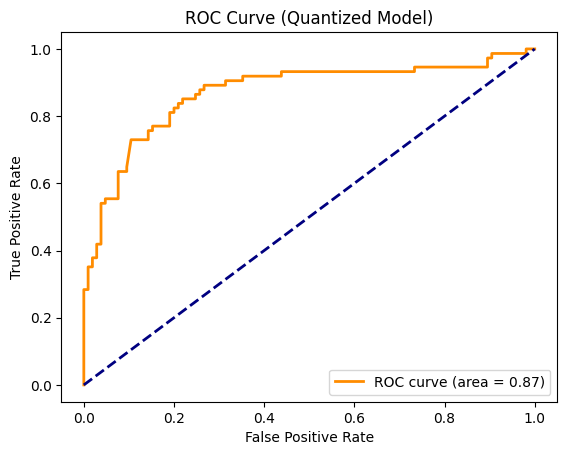

In [ ]:
# Reshape validation data
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# Evaluate the quantized model
y_val_proba_quantized = evaluate_quantized_model(interpreter, X_val_reshaped, y_val)


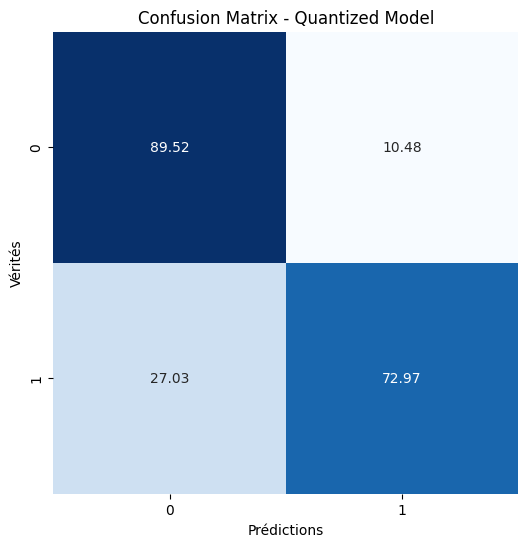

In [ ]:
# Confusion Matrix - Quantized Model
conf_matrix_quantized_percent = conf_matrix_quantized.astype('float') / conf_matrix_quantized.sum(axis=1, keepdims=True) * 100

# Afficher la matrice de confusion en pourcentage
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_quantized_percent, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Quantized Model")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.show()
